# 一、前期工作

本文将采用CNN实现花朵彩色图片分类

🔥本文 GitHub [https://github.com/kzbkzb/Python-AI](https://github.com/kzbkzb/Python-AI) 已收录

- 作者：[K同学啊](https://mp.weixin.qq.com/s/NES9RhtAhbX_jsmGua28dA)
- 来自专栏：《深度学习100例》-Tensorflow2版本

我的环境：

- 语言环境：Python3.6.5
- 编译器：jupyter notebook
- 深度学习环境：TensorFlow2

来自专栏：[**【深度学习100例】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

## 1. 设置GPU

如果使用的是CPU可以忽略这步

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]                                        #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")

## 2. 下载数据

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers,models

import pathlib

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file(fname    = 'flower_photos', # 下载到本地后的文件名称
                                   origin   = dataset_url,     # 数据集(Dataset)的URL路径；
                                   untar    = True,            # 是否解压文件
                                   cache_dir= 'D:/jupyter notebook/DL-100-days')

data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('D:/jupyter notebook/DL-100-days/datasets/flower_photos')

最后数据被保存到`D:\jupyter notebook\DL-100-days\datasets\flower_photos`目录下

## 3. 检查数据

数据集一共分为`daisy`、`dandelion`、`roses`、`sunflowers`、`tulips`五类，分别存放于flower_photo文件夹中的五个子文件夹中

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))

print("图片总数为：",image_count)

图片总数为： 3670


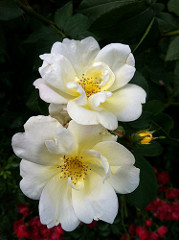

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
"""
关于image_dataset_from_directory()的详细介绍可以参考文章：https://mtyjkh.blog.csdn.net/article/details/117018789
"""
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 2. 可视化数据

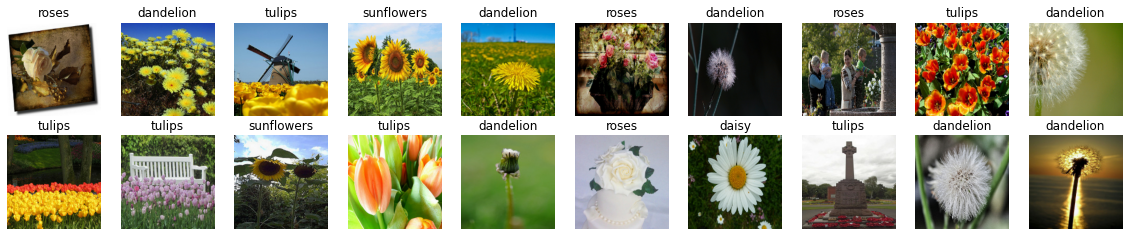

In [10]:
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 10, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

## 3. 再次检查数据 

In [11]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


- `Image_batch`是形状的张量（32,180,180,3）。这是一批形状180x180x3的32张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（32，）的张量，这些标签对应32张图片

## 4. 配置数据集

- **shuffle()**：打乱数据，关于此函数的详细介绍可以参考：https://zhuanlan.zhihu.com/p/42417456
- **prefetch()**：预取数据，加速运行

`prefetch()`功能详细介绍：CPU 正在准备数据时，加速器处于空闲状态。相反，当加速器正在训练模型时，CPU 处于空闲状态。因此，训练所用的时间是 CPU 预处理时间和加速器训练时间的总和。`prefetch()`将训练步骤的预处理和模型执行过程重叠到一起。当加速器正在执行第 N 个训练步时，CPU 正在准备第 N+1 步的数据。这样做不仅可以最大限度地缩短训练的单步用时（而不是总用时），而且可以缩短提取和转换数据所需的时间。如果不使用`prefetch()`，CPU 和 GPU/TPU 在大部分时间都处于空闲状态：

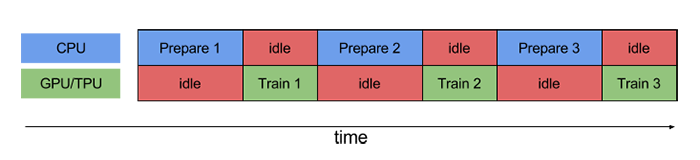

使用`prefetch()`可显著减少空闲时间：

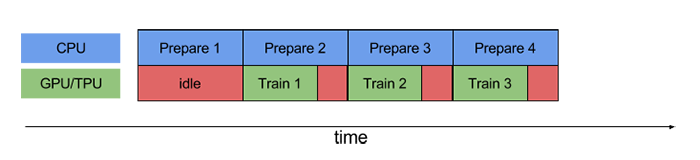

- **cache()**：将数据集缓存到内存当中，加速运行

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、构建CNN网络

卷积神经网络（CNN）的输入是张量 (Tensor) 形式的 `(image_height, image_width, color_channels)`，包含了图像高度、宽度及颜色信息。不需要输入`batch size`。color_channels 为 (R,G,B) 分别对应 RGB 的三个颜色通道（color channel）。在此示例中，我们的 CNN 输入，fashion_mnist 数据集中的图片，形状是 `(28, 28, 1)`即灰度图像。我们需要在声明第一层时将形状赋值给参数`input_shape`。

In [18]:
num_classes = 5

"""
关于卷积核的计算不懂的可以参考文章：https://blog.csdn.net/qq_38251616/article/details/114278995
"""

model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 107584)           

# 四、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于测量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 五、训练模型

In [15]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
92/92 [==============================] - 9s 29ms/step - loss: 1.7851 - accuracy: 0.3435 - val_loss: 1.0564 - val_accuracy: 0.5640
Epoch 2/10
92/92 [==============================] - 1s 11ms/step - loss: 1.0037 - accuracy: 0.5867 - val_loss: 1.0490 - val_accuracy: 0.5708
Epoch 3/10
92/92 [==============================] - 1s 11ms/step - loss: 0.8206 - accuracy: 0.6746 - val_loss: 0.9763 - val_accuracy: 0.6158
Epoch 4/10
92/92 [==============================] - 1s 12ms/step - loss: 0.6061 - accuracy: 0.7864 - val_loss: 0.9745 - val_accuracy: 0.6158
Epoch 5/10
92/92 [==============================] - 1s 12ms/step - loss: 0.3319 - accuracy: 0.8929 - val_loss: 1.2550 - val_accuracy: 0.6076
Epoch 6/10
92/92 [==============================] - 1s 11ms/step - loss: 0.1607 - accuracy: 0.9473 - val_loss: 1.4897 - val_accuracy: 0.6172
Epoch 7/10
92/92 [==============================] - 1s 11ms/step - loss: 0.0864 - accuracy: 0.9757 - val_loss: 1.5388 - val_accuracy: 0.6226
Epoch 8/10
92

# 六、模型评估

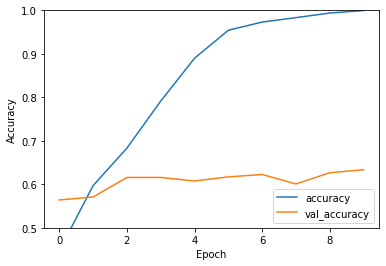

23/23 - 0s - loss: 2.1597 - accuracy: 0.6335


In [16]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

从上面可以看出随着迭代次数的增加，训练准确率与验证准确率之间的差距逐步增加，这是由于过拟合导致，解决办法请参考我的下一篇文章

**《深度学习100例》专栏直达：**[**【传送门】**](https://blog.csdn.net/qq_38251616/category_11068756.html)

In [17]:
print("验证准确率为：",test_acc)

验证准确率为： 0.6335150003433228
